In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

pandas    : 1.3.0
seaborn   : 0.11.1
numpy     : 1.21.0
matplotlib: 3.4.2



In [2]:
from scipy import interpolate

# https://github.com/DaniRuizPerez/PALM-Public-Respository/blob/master/Alignment/getAlignmentsIBD_Taxa.py

#Use B-spline to extrapolate values. NOTE: Parameters s must be adjusted appropriately to avoid over-fitting.
# tck = interpolate.splrep(timepoints, relativeAbundances, k=3, s=0.001, xb=weekFirstSample, xe=weekLastSample)

In [3]:
df_tax_splines = pd.read_csv("../results/tax_clr_splines.csv", index_col=0)

In [4]:
# PARAMETERS
PRESENCE_THRESHOLD = .25
SAMPLING_RATE = 1
OVERLAP_THRESHOLD = .8

max_study_day_no = df_tax_splines.index.max()
min_study_day_no = df_tax_splines.index.min()

a_values = np.arange(0.01, 3.01, .01)
b_values = np.arange(-max_study_day_no, max_study_day_no + .5, .5)

index_splines = np.arange(min_study_day_no, (max_study_day_no + 1 ) * .8, SAMPLING_RATE, dtype="int")

In [5]:
def linear_warp(a, b, s):
	return (s - b) / a

In [6]:
lb_linear_constraint = (index_splines.max() - index_splines.min()) * OVERLAP_THRESHOLD

In [7]:
def inv_linear_warp(a, b, s):
	return (a*s) + b

In [8]:
usernames = df_tax_splines["UserName"].unique()

In [9]:
df_tax_counts = pd.read_csv("../data/taxonomy_counts_s_top.txt", index_col=0, sep="\t")
df_mapping = pd.read_csv("../data/SampleID_map.txt", sep='\t', index_col=0)

In [10]:
df_tax_counts = df_tax_counts.T

df_tax_counts.index.name = "#SampleID"

df_tax_counts_username = pd.merge(df_tax_counts, df_mapping.reset_index()[["#SampleID", "UserName"]], on="#SampleID", how="left")

df_tax_counts_username = df_tax_counts_username.set_index("#SampleID")

df_username_presence = df_tax_counts_username.groupby("UserName").apply(lambda x: (x > 0).sum() / x.shape[0])

In [11]:
import pickle
with open("../results/d_splines.pkl", "rb") as inf:
    d_splines = pickle.load(inf)

In [12]:
# d_splines[reference]['k__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_adolescentis']

In [13]:
a = 1.5
b = -5

# usernames
# reference
# PRESENCE_THRESHOLD
# d_splines

def error_a_b_reference(ab, reference, current, presence_threshold, d_splines, overlap_threshold):
    a = ab[0]
    b = ab[1]
    reference_inv_warp = inv_linear_warp(a, b, index_splines)

    # alpha is the max(reference_sample, inv_linear_warp(current_sample))
    # beta is the min(reference_sample_t, inv_linear_warp(current_sample))
    alpha = max(index_splines.min(), reference_inv_warp.min())
    beta = min(index_splines.max(), reference_inv_warp.max())

    overlap =  (beta - alpha) / (index_splines.max() - index_splines.min())

#     if overlap > overlap_threshold and alpha < beta:
    error = get_alignment_error(a, b, alpha, beta, index_splines, reference, current, presence_threshold, d_splines)
#     else:
#         error = get_alignment_error(1, 0, index_splines.min(), index_splines.max(), index_splines, reference, usernames, presence_threshold, d_splines)
    return error

In [14]:
# def get_alignment_error(a, b, alpha, beta, index_splines, reference, current, presence_threshold, d_splines):
#     current_warp = linear_warp(a, b, index_splines)
#     reference_taxonomies = set(df_username_presence.loc[reference, df_username_presence.loc[reference, :] > PRESENCE_THRESHOLD].index)

#     current_taxonomies = set(df_username_presence.loc[current, df_username_presence.loc[current, :] > PRESENCE_THRESHOLD].index)
#     filtered_taxonomies = reference_taxonomies.intersection(current_taxonomies)
    
#     error_tax = np.repeat(0.0, len(filtered_taxonomies))
    
#     for ix_tax, taxonomy in enumerate(filtered_taxonomies):
#         spline_reference, reference_min, reference_max = d_splines[reference][taxonomy]
#         spline_current, current_min, current_max = d_splines[current][taxonomy]
#         ts_current = interpolate.splev(index_splines, spline_current)
#         ts_current = np.clip(ts_current_warp, current_min, current_max)
        
#         spline = interpolate.splrep(current_warp, values, k=3, xb=min_subj_study_day_no, xe=max_subj_study_day_no)

        
#         spline_values = interpolate.splev(spline_timepoints, spline)
        

#         ts_reference = interpolate.splev(index_splines, spline_reference)
#         ts_current_warp = interpolate.splev(current_warp, spline_current)

#         ts_reference = np.clip(ts_reference, reference_min, reference_max)
#         ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

#         cur_error = np.linalg.norm(ts_reference - ts_current_warp)
#         cur_error = cur_error / (beta - alpha)
#         error_tax[ix_tax] = cur_error
#     return np.mean(error_tax)

In [15]:
def get_alignment_error(a, b, alpha, beta, index_splines, reference, current, presence_threshold, d_splines):
    current_warp = linear_warp(a, b, index_splines)
    reference_taxonomies = set(df_username_presence.loc[reference, df_username_presence.loc[reference, :] > PRESENCE_THRESHOLD].index)

    current_taxonomies = set(df_username_presence.loc[current, df_username_presence.loc[current, :] > PRESENCE_THRESHOLD].index)
    filtered_taxonomies = reference_taxonomies.intersection(current_taxonomies)
    
    error_tax = np.repeat(0.0, len(filtered_taxonomies))
    
    for ix_tax, taxonomy in enumerate(filtered_taxonomies):
        spline_reference, reference_min, reference_max = d_splines[reference][taxonomy]
        spline_current, current_min, current_max = d_splines[current][taxonomy]

        ts_reference = interpolate.splev(index_splines, spline_reference)
        ts_current_warp = interpolate.splev(current_warp, spline_current)

        ts_reference = np.clip(ts_reference, reference_min, reference_max)
        ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

        cur_error = np.linalg.norm(ts_reference - ts_current_warp)
        cur_error = cur_error / (beta - alpha)
        error_tax[ix_tax] = cur_error
    return np.mean(error_tax)

In [16]:
from scipy.optimize import minimize

In [17]:
def gen_constraint_overlap(index_splines):
    def inner_constraint(ab):
        a = ab[0]
        b = ab[1]
        reference_inv_warp = inv_linear_warp(a, b, index_splines)

        # alpha is the max(reference_sample, inv_linear_warp(current_sample))
        # beta is the min(reference_sample_t, inv_linear_warp(current_sample))
        alpha = max(index_splines.min(), reference_inv_warp.min())
        beta = min(index_splines.max(), reference_inv_warp.max())

        overlap =  (beta - alpha) / (index_splines.max() - index_splines.min())
        return overlap
    return inner_constraint
    
def gen_constraint_greater_than(index_splines):
    def inner_constraint(ab):
        a = ab[0]
        b = ab[1]
        reference_inv_warp = inv_linear_warp(a, b, index_splines)
#         reference_inv_warp = linear_warp(a, b, index_splines)

        # alpha is the max(reference_sample, inv_linear_warp(current_sample))
        # beta is the min(reference_sample_t, inv_linear_warp(current_sample))
        alpha = max(index_splines.min(), reference_inv_warp.min())
        beta = min(index_splines.max(), reference_inv_warp.max())

        return beta - alpha
    return inner_constraint

In [18]:
import itertools

In [19]:
bounds = [(0.01, 3), (-15, 15)]

from scipy.optimize import NonlinearConstraint, LinearConstraint

constraint_overlap = NonlinearConstraint(gen_constraint_overlap(index_splines), lb=OVERLAP_THRESHOLD, ub=np.inf)
constraint_gt = NonlinearConstraint(gen_constraint_greater_than(index_splines), lb=0, ub=np.inf)
constraint_cobyla_a = LinearConstraint((1,0), lb=0.01, ub=3)
constraint_cobyla_b = LinearConstraint((0,1), lb=-15, ub=15)

# reference = usernames[0]

# results = []

def yield_results(reference, current):
    res = minimize(
        error_a_b_reference,
        method="COBYLA",
        x0=[1, 0.0],
        args=(reference, current, PRESENCE_THRESHOLD, d_splines, OVERLAP_THRESHOLD),
        constraints=(constraint_overlap, constraint_gt, constraint_cobyla_a, constraint_cobyla_b),
    #     bounds=bounds,
    )
    return reference, current, res
    

# for (reference, current) in itertools.product(usernames, usernames):
# #     if reference == current:
# #         continue
#     res = minimize(
#         error_a_b_reference,
#         method="COBYLA",
#         x0=[1, 0.0],
#         args=(reference, current, PRESENCE_THRESHOLD, d_splines, OVERLAP_THRESHOLD),
#         constraints=(constraint_overlap, constraint_gt, constraint_cobyla_a, constraint_cobyla_b),
#     #     bounds=bounds,
#     )
# #     if not res.success:
# #             res = minimize(
# #                     error_a_b_reference,
# #                     method="COBYLA",
# #                     x0=[1, 0.0],
# #                     args=(reference, current, PRESENCE_THRESHOLD, d_splines, OVERLAP_THRESHOLD),
# #                     constraints=(constraint_overlap, constraint_gt, constraint_cobyla_a, constraint_cobyla_b),
# #                 #     bounds=bounds,
# #             )
#     results.append((reference, current, res))

In [20]:
import multiprocessing
pool = multiprocessing.Pool(40)
results = pool.starmap(yield_results, itertools.product(usernames, usernames))

In [21]:
res = minimize(
    error_a_b_reference,
    method="COBYLA",
    x0=[1, 0.0],
    args=("MCTs36", "MCTs36", PRESENCE_THRESHOLD, d_splines, OVERLAP_THRESHOLD),
    constraints=(constraint_overlap, constraint_gt, constraint_cobyla_a, constraint_cobyla_b),
#     bounds=bounds,
)

In [22]:
res

     fun: 0.0012428127053670554
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 25
  status: 1
 success: True
       x: array([1.00009906e+00, 1.36673254e-05])

In [23]:
mat = []
cols = ["reference", "current", "error", "a", "b"]
for result in results:
    res = result[2]
    mat.append([result[0], result[1], res.fun, res.x[0], res.x[1]])

df_alignment_results = pd.DataFrame(mat, columns=cols)

In [24]:
result

('MCTs37',
 'MCTs37',
      fun: 0.0011367775144044891
    maxcv: 0.0
  message: 'Optimization terminated successfully.'
     nfev: 25
   status: 1
  success: True
        x: array([1.00009920e+00, 1.26558415e-05]))

In [25]:
df_alignment_error = df_alignment_results.pivot(index="reference", columns="current", values="error").copy()

In [26]:
df_alignment_error.values[[np.arange(df_alignment_error.shape[0])]*2] = 0

/tmp/ipykernel_2391/4059380397.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_alignment_error.values[[np.arange(df_alignment_error.shape[0])]*2] = 0


In [27]:
best_aligner = df_alignment_error.mean(axis=1).sort_values().index[0]

In [28]:
drop_users = df_alignment_error.index[df_alignment_error[best_aligner] > df_alignment_error[best_aligner].mean() + (2*df_alignment_error[best_aligner].std())]
drop_users

Index(['MCTs30'], dtype='object', name='reference')

In [29]:
import plot_utils as pu
pu.figure_setup()

/home/bhillmann/.conda/envs/foodworks/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


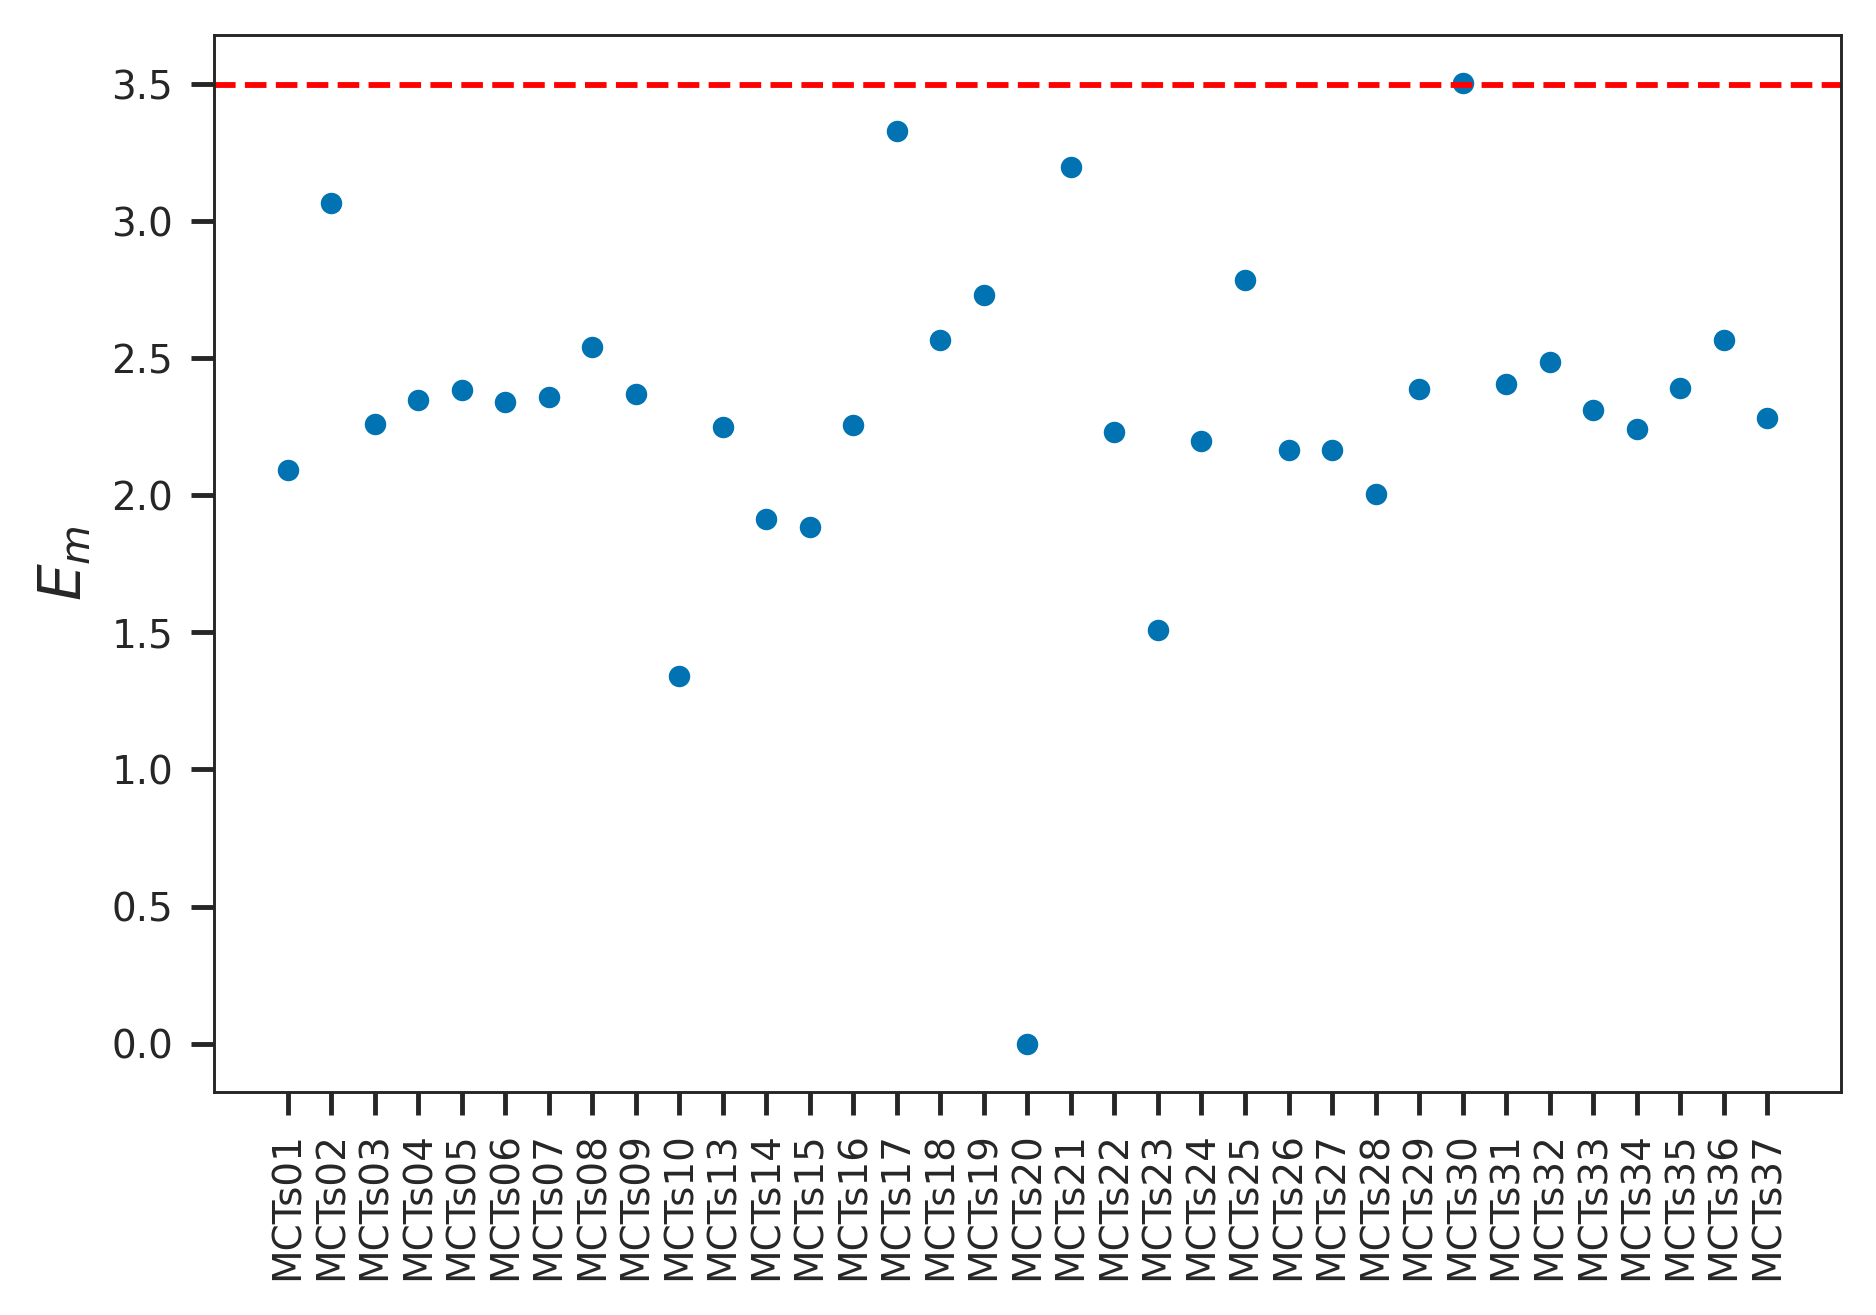

In [30]:
fig, ax = plt.subplots()

sns.scatterplot(df_alignment_error.columns, df_alignment_error[best_aligner].values)
ax.axhline(df_alignment_error[best_aligner].mean() + (2*df_alignment_error[best_aligner].std()), linestyle='--', color="red")

ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel("$E_m$")
ax.set_xlabel("")

pu.save_plot(fig, "error.alignment")

In [31]:
best_aligner

'MCTs20'

In [32]:
# df_alignment_results.query(f"reference == '{best_aligner}'")

In [33]:
# df_alignment_results.query(f"reference == '{reference}' & current == '{current}'")

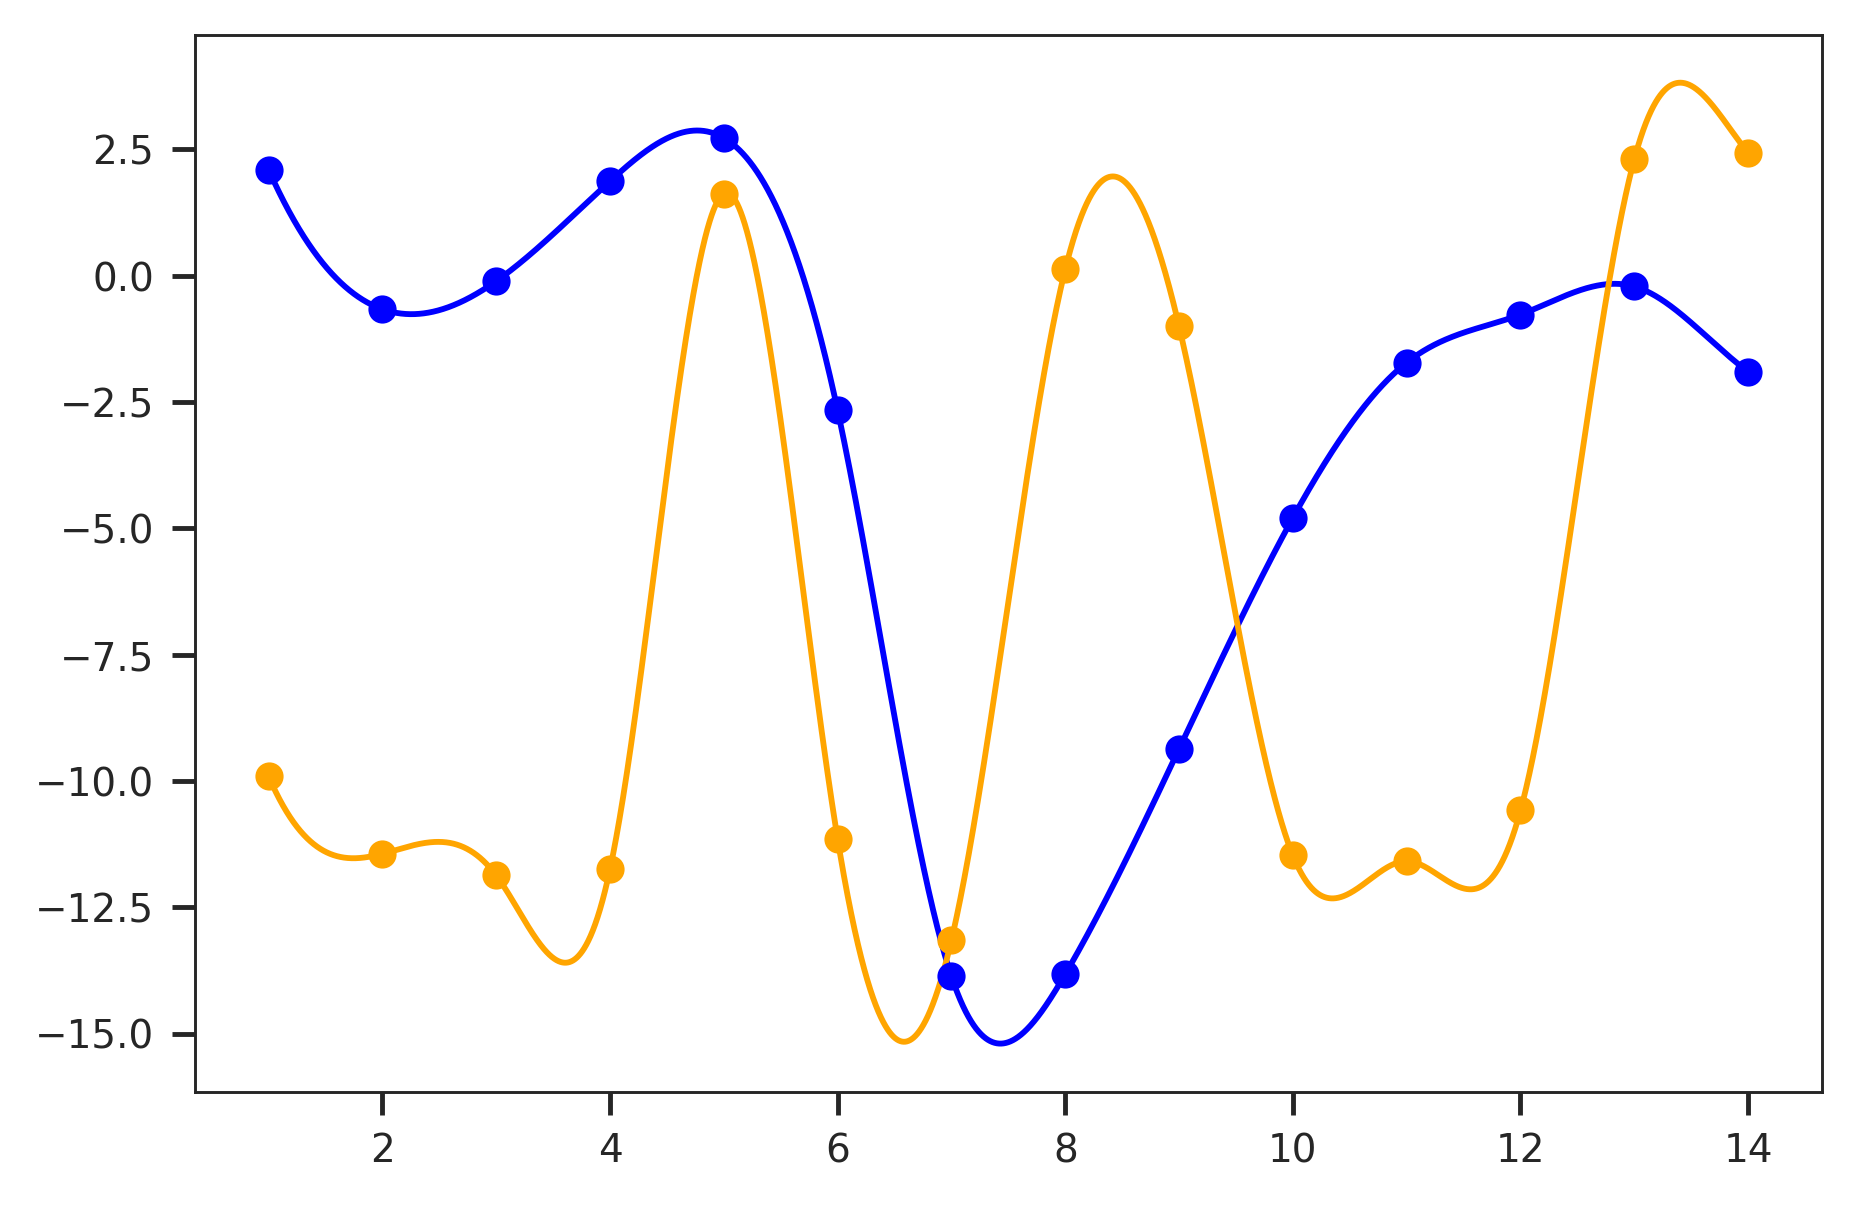

In [34]:
current = "MCTs36"
reference = best_aligner
taxonomy = 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli'

# for row in df_alignment_results.query(f"reference == '{best_aligner}'").iterrrows():

row = df_alignment_results.query(f"reference == '{reference}' & current == '{current}'")

spline_reference, reference_min, reference_max = d_splines[reference][taxonomy]
spline_current, current_min, current_max = d_splines[current][taxonomy]

index_smooth_current = np.linspace(index_splines.min(), index_splines.max(), 10_000)
current_smooth_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_smooth_current)

ts_reference_smooth_warp = interpolate.splev(index_smooth_current, spline_reference)
ts_current_smooth_warp = interpolate.splev(current_smooth_warp, spline_current)

ts_reference_smooth_warp = np.clip(ts_reference_smooth_warp, reference_min, reference_max)
ts_current_smooth_warp = np.clip(ts_current_smooth_warp, current_min, current_max)

current_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

# index_warp_arange = np.arange(np.ceil(current_warp.min()), np.floor(current_warp.max()), dtype=int)

# current_warp = inv_linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

ts_reference = interpolate.splev(index_splines, spline_reference)
ts_current_warp = interpolate.splev(current_warp, spline_current)

ts_reference = np.clip(ts_reference, reference_min, reference_max)
ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

fig, ax = plt.subplots()

plt.plot(index_smooth_current, ts_reference_smooth_warp, color="blue")
plt.plot(index_smooth_current, ts_current_smooth_warp, color="orange")

plt.plot(index_splines, ts_reference, 'o', color="blue")
plt.plot(index_splines, ts_current_warp, 'o', color="orange")

# plt.plot(index_splines, reference_max, 'ob')
plt.show()

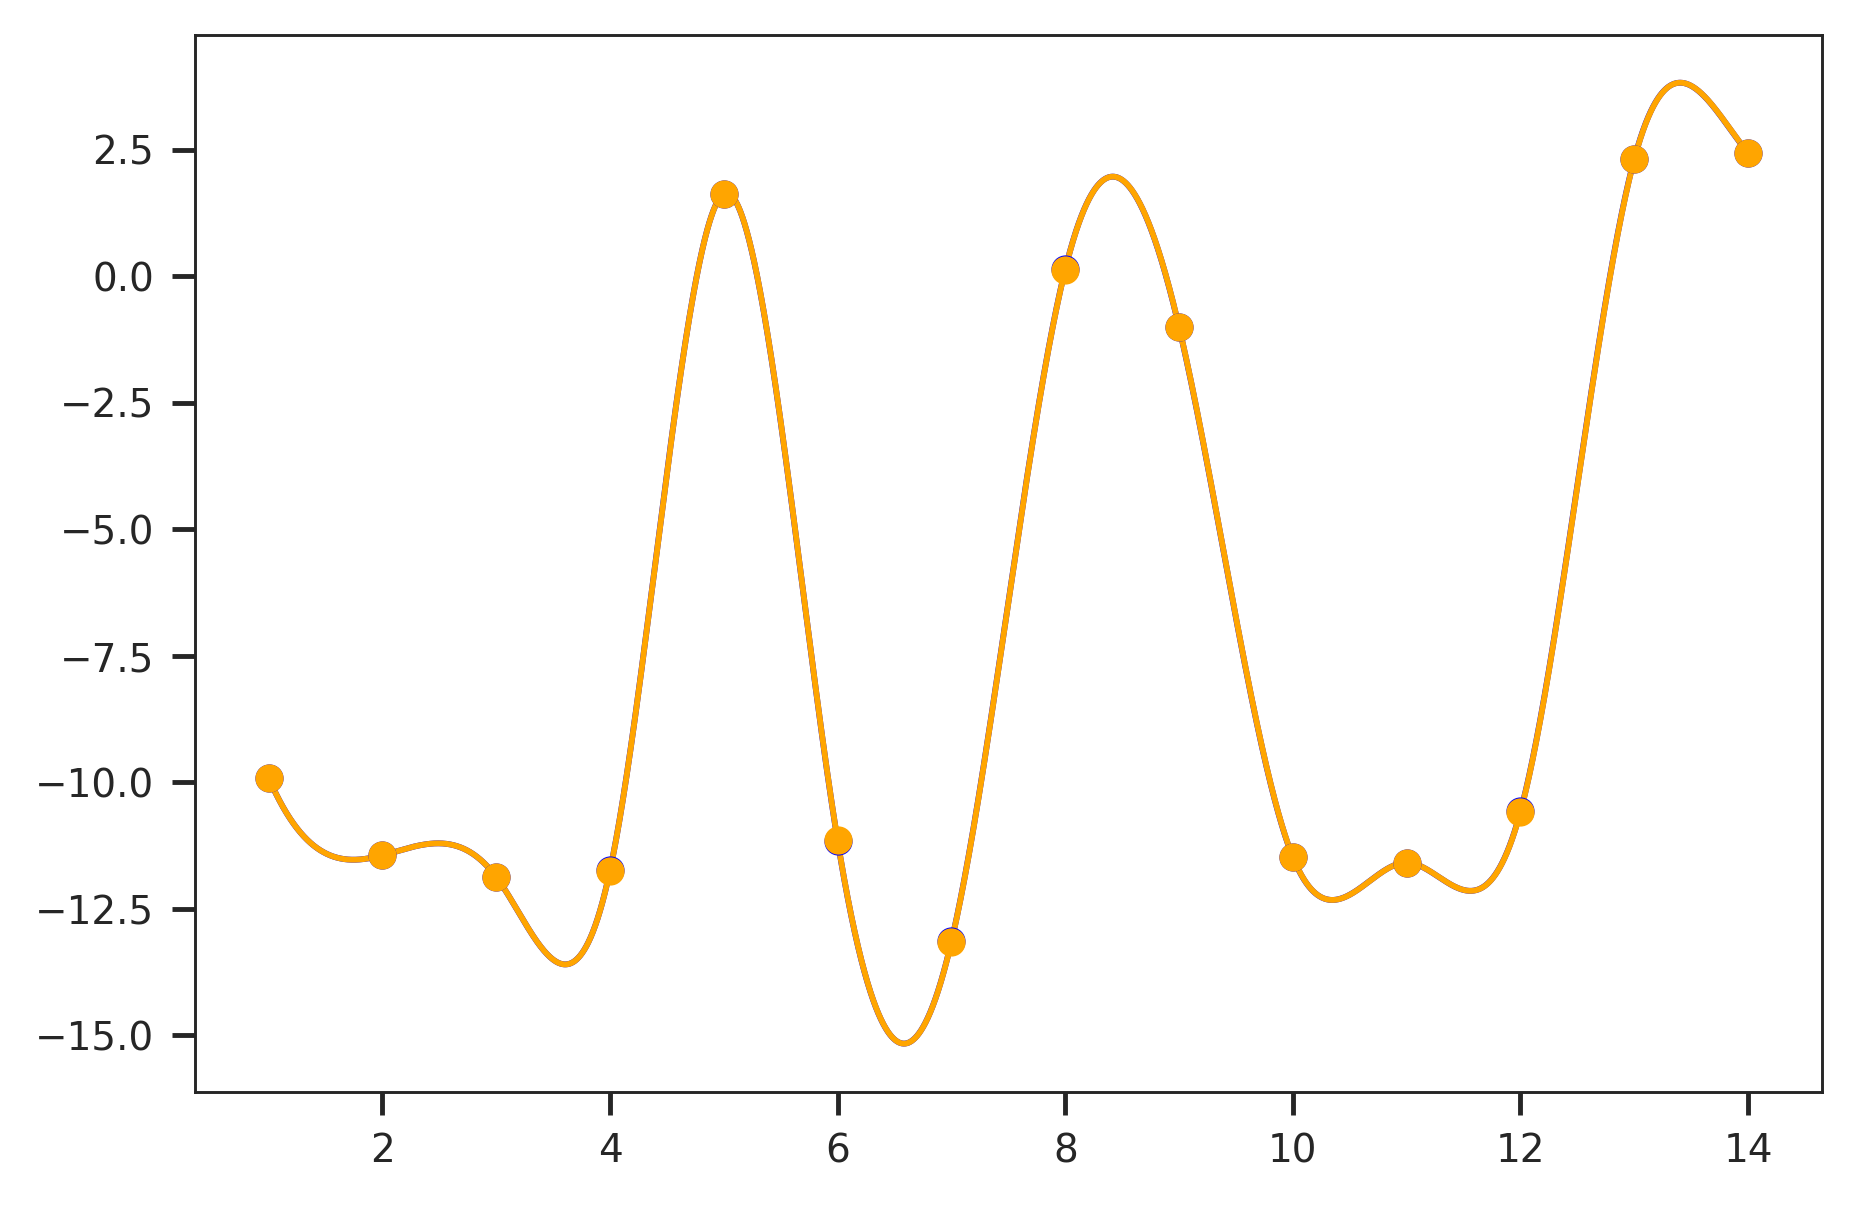

In [35]:
current = "MCTs36"
reference = best_aligner
taxonomy = 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli'

# for row in df_alignment_results.query(f"reference == '{best_aligner}'").iterrrows():

row = df_alignment_results.query(f"reference == '{reference}' & current == '{current}'")

spline_reference, reference_min, reference_max = d_splines[current][taxonomy]
spline_current, current_min, current_max = d_splines[current][taxonomy]

index_smooth_current = np.linspace(index_splines.min(), index_splines.max(), 10_000)
current_smooth_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_smooth_current)

ts_reference_smooth_warp = interpolate.splev(index_smooth_current, spline_reference)
ts_current_smooth_warp = interpolate.splev(current_smooth_warp, spline_current)

ts_reference_smooth_warp = np.clip(ts_reference_smooth_warp, reference_min, reference_max)
ts_current_smooth_warp = np.clip(ts_current_smooth_warp, current_min, current_max)

current_warp = linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

index_warp_arange = np.arange(np.ceil(current_warp.min()), np.floor(current_warp.max()), dtype=int)

# current_warp = inv_linear_warp(row['a'].values[0], row['b'].values[0], index_warp_arange)

ts_reference = interpolate.splev(index_splines, spline_reference)
ts_current_warp = interpolate.splev(current_warp, spline_current)

ts_reference = np.clip(ts_reference, reference_min, reference_max)
ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

fig, ax = plt.subplots()

plt.plot(index_smooth_current, ts_reference_smooth_warp, color="blue")
plt.plot(index_smooth_current, ts_current_smooth_warp, color="orange")

plt.plot(index_splines, ts_reference, 'o', color="blue")
plt.plot(index_splines, ts_current_warp, 'o', color="orange")

# plt.plot(index_splines, reference_max, 'ob')
plt.show()

In [36]:
inv_linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

array([ 1.00013313,  2.00022355,  3.00031397,  4.00040439,  5.00049481,
        6.00058523,  7.00067565,  8.00076607,  9.00085649, 10.00094691,
       11.00103733, 12.00112776, 13.00121818, 14.0013086 ])

In [37]:
index_realtime = linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

In [38]:
inv_linear_warp(row['a'].values[0], row['b'].values[0], index_splines)

array([ 1.00013313,  2.00022355,  3.00031397,  4.00040439,  5.00049481,
        6.00058523,  7.00067565,  8.00076607,  9.00085649, 10.00094691,
       11.00103733, 12.00112776, 13.00121818, 14.0013086 ])

In [39]:
best_aligner

'MCTs20'

In [40]:


taxonomy = 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli'

sample_ids = ["MCTs06", "MCTs10", "MCTs18", "MCTs37", "MCTs20"]
color_map = dict(zip(sample_ids, sns.color_palette("colorblind", 5)))

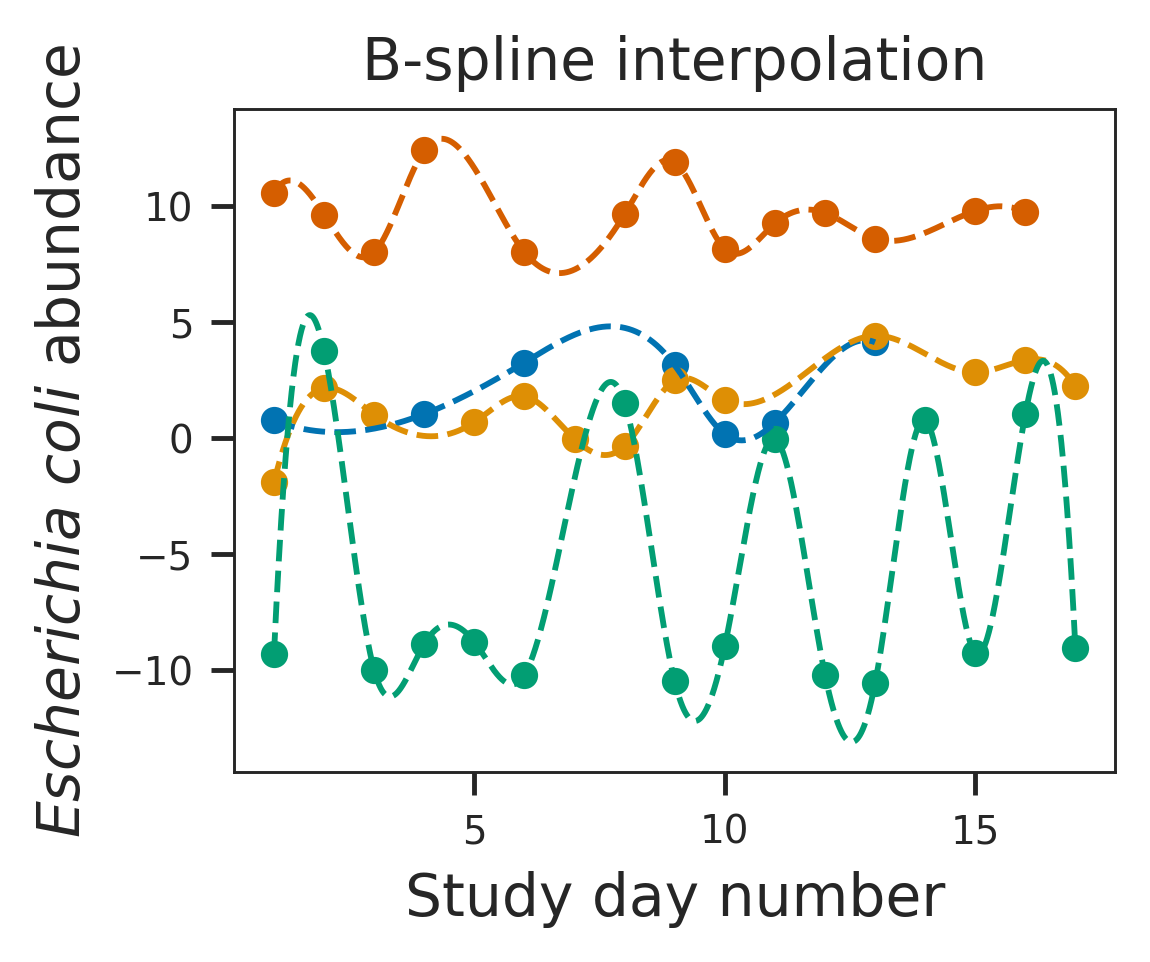

In [41]:
df_plot = pd.read_csv("../data/plot_top.txt", sep='\t', index_col=0)

username_with_tax = set(df_username_presence.loc[df_username_presence.loc[:, taxonomy] > PRESENCE_THRESHOLD].index)

figsize = pu.get_fig_size(6.5 / 2)

fig, ax = plt.subplots(figsize=figsize)

ix = 0
for name, row in df_alignment_results.query(f"reference == '{best_aligner}'").iterrows():
    current = row['current']
    if current in username_with_tax and reference != current and current in color_map:
        spline_current, current_min, current_max = d_splines[current][taxonomy]

        index_smooth_current = np.linspace(index_splines.min(), 17, 10_000)
        current_smooth_warp = linear_warp(row['a'], row['b'], index_smooth_current)
        
        df_current = df_plot.query(f"UserName == '{current}'")
        
        min_ix = df_current["StudyDayNo"].min()
        max_ix = df_current["StudyDayNo"].max()
        
        mask_smooth = (index_smooth_current >= min_ix) & (index_smooth_current <= max_ix)
        
        mask_warp = (current_smooth_warp >= min_ix) & (current_smooth_warp <= max_ix)

        ts_current_smooth = interpolate.splev(index_smooth_current, spline_current)
        ts_current_smooth_warp = interpolate.splev(current_smooth_warp, spline_current)
        ts_current_smooth = np.clip(ts_current_smooth, current_min, current_max)
        ts_current_smooth_warp = np.clip(ts_current_smooth_warp, current_min, current_max)


        current_warp = linear_warp(row['a'], row['b'], index_splines)

        ts_current_warp = interpolate.splev(current_warp, spline_current)
        ts_current_warp = np.clip(ts_current_warp, current_min, current_max)
        ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

        ax.scatter(df_current["StudyDayNo"], df_current["value"], color=color_map[current], label=current)
#         plt.plot(index_smooth_current[mask_warp], ts_current_smooth_warp[mask_warp], color=color_map[current])
        ax.plot(index_smooth_current[mask_smooth], ts_current_smooth[mask_smooth], "--", color=color_map[current], label=f"{current} spline")
#         plt.plot(index_splines, ts_current_warp, 'o', color=color_map[current])
        ix += 1

ax.set_ylabel("$Escherichia\\ coli$ abundance")
ax.set_xlabel("Study day number")

ax.set_title("B-spline interpolation")

legend = ax.legend()
handles = [_ for _ in legend.legendHandles]
legend.remove()

# plt.plot(index_splines, reference_max, 'ob')
pu.save_plot(fig, "samples.b.spline.interpolation")

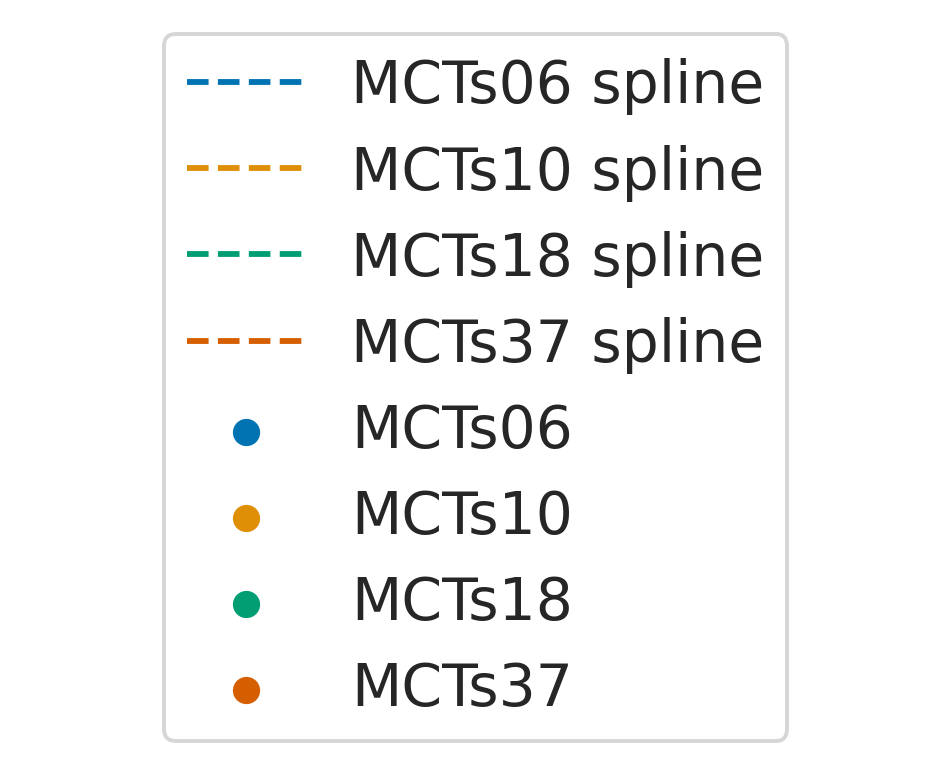

In [42]:
artists = ax.legend()

figsize = pu.get_fig_size(6.5 / 2)
fig, ax = plt.subplots(figsize=figsize)

_artists = ax.legend(loc="center", handles=artists.legendHandles)

plt.axis('off')
pu.save_plot(fig, f"samples.b.spline.interpolation.legend", artists=(_artists,))

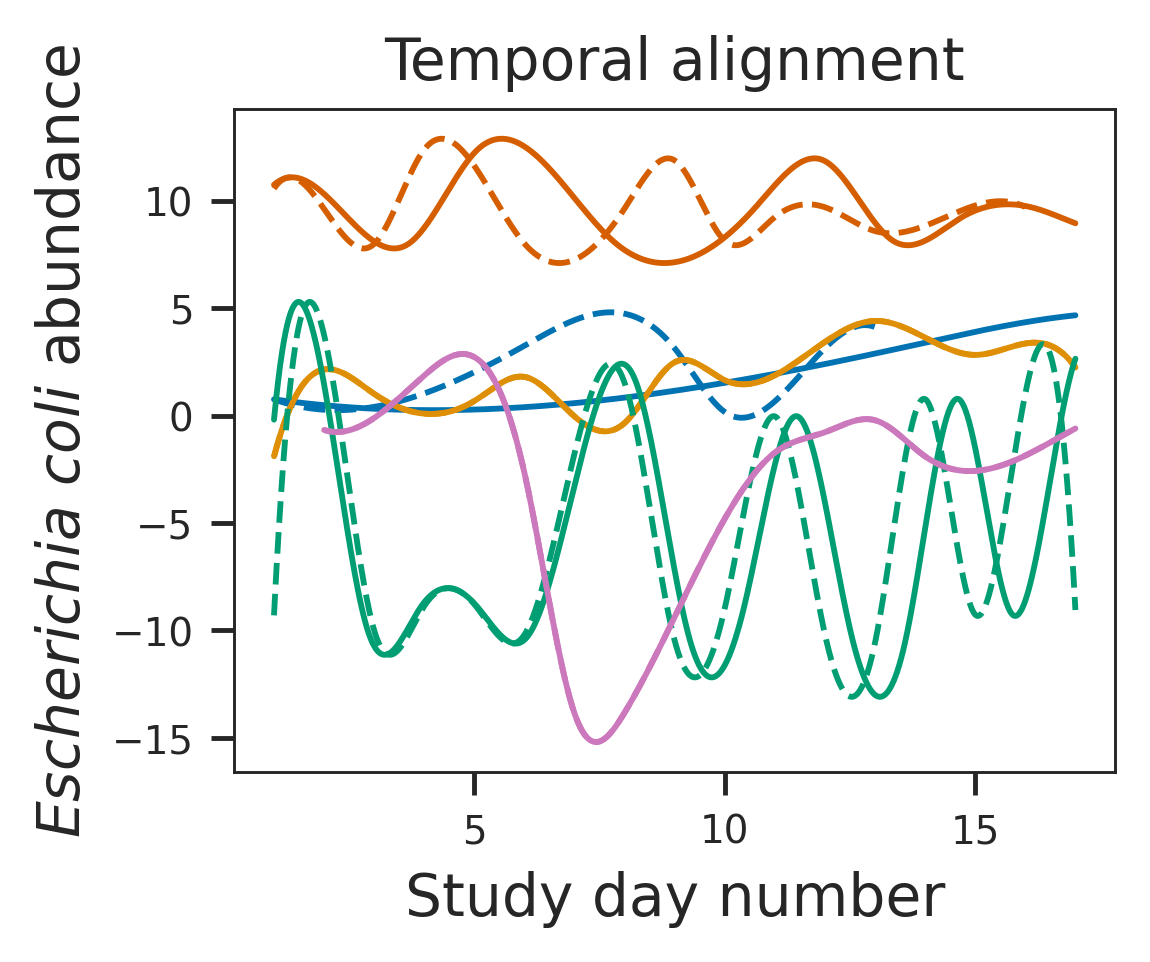

In [43]:
df_plot = pd.read_csv("../data/plot_top.txt", sep='\t', index_col=0)

username_with_tax = set(df_username_presence.loc[df_username_presence.loc[:, taxonomy] > PRESENCE_THRESHOLD].index)

figsize = pu.get_fig_size(6.5 / 2)

fig, ax = plt.subplots(figsize=figsize)

for name, row in df_alignment_results.query(f"reference == '{best_aligner}'").iterrows():
    current = row['current']
    if current in color_map:
        spline_current, current_min, current_max = d_splines[current][taxonomy]

        index_smooth_current = np.linspace(index_splines.min(), 17, 10_000)
        current_smooth_warp = linear_warp(row['a'], row['b'], index_smooth_current)
        
        df_current = df_plot.query(f"UserName == '{current}'")
        
        min_ix = df_current["StudyDayNo"].min()
        max_ix = df_current["StudyDayNo"].max()
        
        mask_smooth = (index_smooth_current >= min_ix) & (index_smooth_current <= max_ix)
        
        mask_warp = (current_smooth_warp >= min_ix) & (current_smooth_warp <= max_ix)

        ts_current_smooth = interpolate.splev(index_smooth_current, spline_current)
        ts_current_smooth_warp = interpolate.splev(current_smooth_warp, spline_current)
        ts_current_smooth = np.clip(ts_current_smooth, current_min, current_max)
        ts_current_smooth_warp = np.clip(ts_current_smooth_warp, current_min, current_max)


        current_warp = linear_warp(row['a'], row['b'], index_splines)

        ts_current_warp = interpolate.splev(current_warp, spline_current)
        ts_current_warp = np.clip(ts_current_warp, current_min, current_max)
        ts_current_warp = np.clip(ts_current_warp, current_min, current_max)

        ax.plot(index_smooth_current[mask_warp], ts_current_smooth_warp[mask_warp], color=color_map[current], label=f"{current} aligned")
        ax.plot(index_smooth_current[mask_smooth], ts_current_smooth[mask_smooth], "--", color=color_map[current], label=f"{current} spline")
#         plt.plot(index_splines, ts_current_warp, 'o', color=color_map[current])
        ix += 1

ax.set_ylabel("$Escherichia\\ coli$ abundance")
ax.set_xlabel("Study day number")

ax.set_title("Temporal alignment")
legend = ax.legend()
handles = [_ for _ in legend.legendHandles]
legend.remove()

# plt.plot(index_splines, reference_max, 'ob')
pu.save_plot(fig, "samples.temporal.alignment")

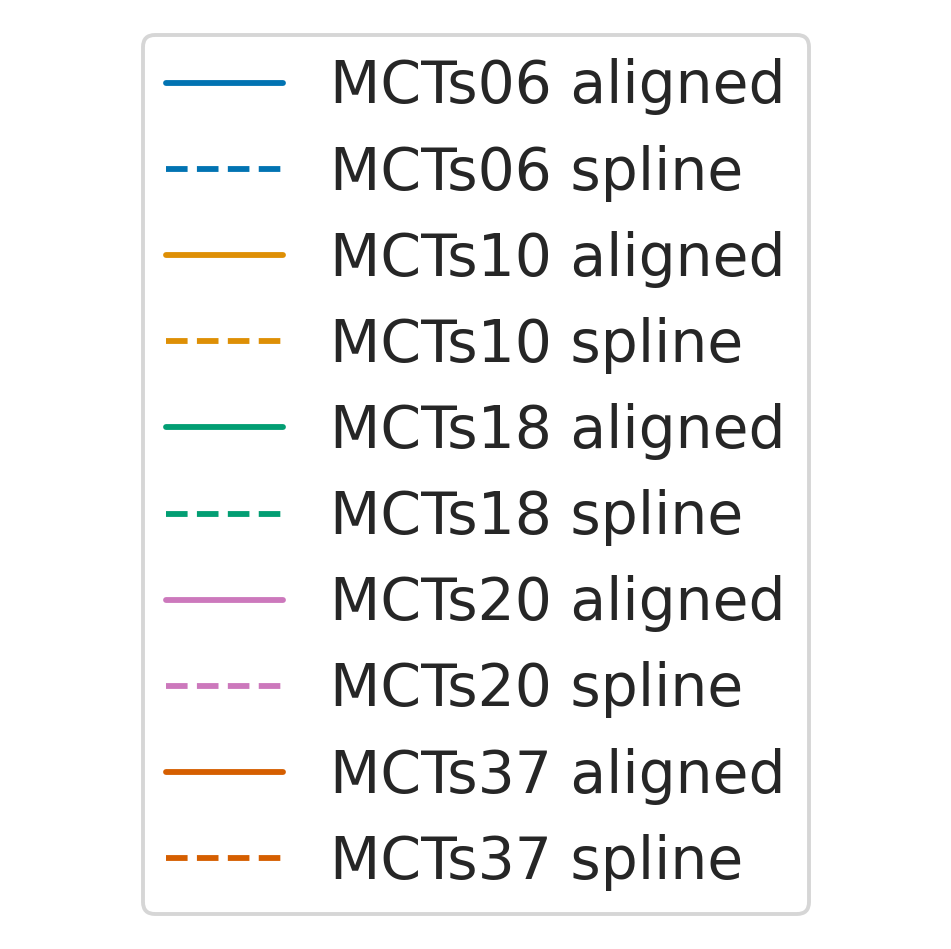

In [44]:
artists = ax.legend()

figsize = pu.get_fig_size(6.5 / 2)
fig, ax = plt.subplots(figsize=figsize)

_artists = ax.legend(loc="center", handles=artists.legendHandles)

plt.axis('off')
pu.save_plot(fig, f"samples.temporal.alignment.legend", artists=(_artists,))

In [45]:
df_alignment_results.to_csv("../results/alignment_results.txt", sep="\t", index=False)

In [46]:
# 			T = [warpFunction(a, b, timepointReferenceSample.offsetID) for timepointReferenceSample in timepointsListReferenceSample]
# ##			T_inverse = [warpFunctionInverse(a, b, timepointCurrentSample.offsetID) for timepointCurrentSample in timepointsListCurrentSample]
# 			timepointCurrentSampleMin = warpFunctionInverse(a, b, min(CurrentSampleT))
# 			timepointCurrentSampleMax = warpFunctionInverse(a, b, max(CurrentSampleT))
# 			alpha = max(timepointReferenceSampleMin, timepointCurrentSampleMin)
# 			beta = min(timepointReferenceSampleMax, timepointCurrentSampleMax)
# 			overlap =  (beta - alpha) / (timepointReferenceSampleMax - timepointReferenceSampleMin)
# 			if overlap > OVERLAP_THRESHOLD and alpha < beta:
# 				[alignmentError, a, b] = getAlignmnetError(a, b, alpha, beta, timepointsListReferenceSample, timepointsListCurrentSample, taxonWeights, useSplines)
# 				if len(optimalAlignmentParameters) == 0 or optimalAlignmentParameters[0] > alignmentError:
# 					optimalAlignmentParameters = [alignmentError, a, b, alpha, beta, overlap]